In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import scipy
%matplotlib inline
import numpy as np

Esse notebook tem o objetivo de analisar os resultados para a base synth2.

# 1 - Fitness por execução

In [3]:
results_folder_path = pathlib.Path('../../results/')

In [4]:
def get_fitness_data_per_config(folders_paths) -> list[dict]:
    data_per_config = dict()
    for target_folder in folders_paths:
        fitness_stats_path = target_folder / 'fitness_stats.csv'
        print(fitness_stats_path)
        stats_df = pd.read_csv(fitness_stats_path)
        config_name = str(target_folder).split('/')[-1].split('_')[1]
        data_per_config[config_name] = stats_df
    return data_per_config

In [5]:
results_folders = list(results_folder_path.glob("synth2/100pop*"))
data = get_fitness_data_per_config(results_folders)

../../results/synth2/100pop_500gen/fitness_stats.csv


In [6]:
data['500gen'].head()

,train_fit,test_fit,train_time_seconds,random_seed
0,3.097931,3.674764,24.383076,350
1,3.124490,3.468929,22.485794,279
2,2.077842,2.403279,83.938711,25
3,2.640279,3.116975,82.841530,137
4,2.589962,2.881810,65.268862,59


In [7]:
def plot_fitness_results(data_dict, num_inds, num_runs=30, base_dados='synth1'):
    train_data_colors = { 
                     '500gen':'green'
    }

    test_data_colors = { 
                     '500gen':'black'
    }

    x = range(num_runs)
    fig, ax = plt.subplots(figsize=(9, 6))
    for config, data in data_dict.items():
            ax.plot(x, data['train_fit'], color=train_data_colors[config], label=config+" train")
            ax.plot(x, data['test_fit'], color=test_data_colors[config], label=config+" test")

    plt.title(f"Melhor Fitness treino e teste base {base_dados} para {num_inds} indivíduos")
    plt.xlabel("Número da Execução")
    plt.ylabel("Fitness")
    plt.legend()
    plt.show()

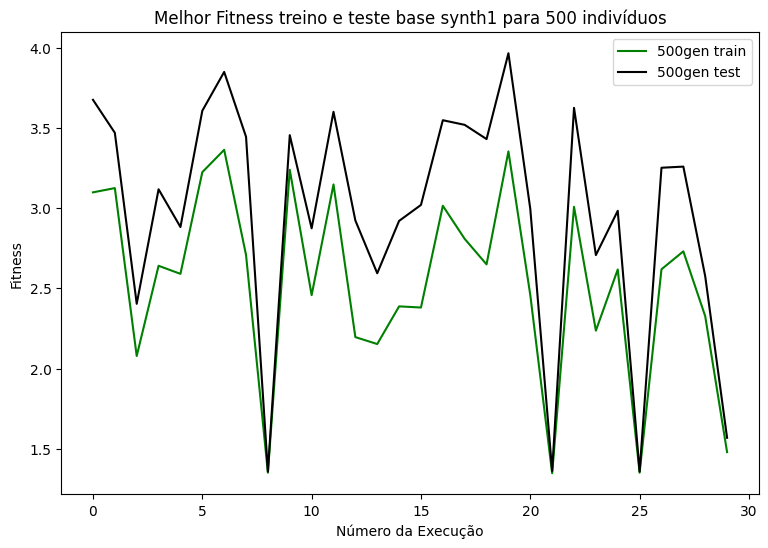

In [8]:
plot_fitness_results(data, num_inds=500)

In [9]:
def get_trimmed_mean_train_test_fitness(data_dict, trim=0.05)-> dict[str, dict]:
    config_dict_results = dict()
    for config, data in data_dict.items():
        config_dict_results[config] = dict()
        config_dict_results[config]['train'] = scipy.stats.trim_mean(data.train_fit, trim)
        config_dict_results[config]['test'] = scipy.stats.trim_mean(data.test_fit, trim)
    return config_dict_results

In [10]:
mean_results = get_trimmed_mean_train_test_fitness(data)
mean_results

{'500gen': {'train': 2.5506825539033855, 'test': 3.000227009564529}}

# 2 - Seed da melhor execução 

In [11]:
def get_best_test_line_for_gen(num_gens):
    target = f'{num_gens}gen'
    config = data[target]
    print(f"Melhor linha para 500 indivíduos: ")
    print(config[config.test_fit == config.test_fit.min()])

In [12]:
get_best_test_line_for_gen(500)

Melhor linha para 500 indivíduos: 
    train_fit  test_fit  train_time_seconds  random_seed
8    1.350817  1.357752           73.085844          173
25   1.350817  1.357752          107.472568          942


Interessantemente, para duas execuções com duas seeds diferentes, temos exxatamente o mesmo resultado. Talvez, ambas tenham encontrado o mesmo indivíduo ao final.

# 3 - Fitness por geração todas execuções

In [13]:
def get_500_gen_stats_df_dict_by_run_of_folder(base_folder):
    for folder in list(base_folder):
        if str(folder).split("_")[-1] == '500gen':
            files = list(folder.glob("stats*"))
            stats_dict = dict()
            for file in files:
                file_num = str(file).split('_')[-1].split('.')[0]
                stats_dict[int(file_num)] = pd.read_csv(file)
            return stats_dict

In [14]:
stats_by_run = get_500_gen_stats_df_dict_by_run_of_folder(results_folders)

In [15]:
def get_line_and_col_of_runs(df_dict, target_line, target_cols:list):
    results_list_of_dicts = list()
    for df_num, df in df_dict.items():
        results_list_of_dicts.append(df.iloc[target_line][target_cols].to_dict())
    
    return pd.DataFrame(results_list_of_dicts)

def get_col_stats_from_dfs_dict(df_dict, target_col):
    records_list = list()
    for gen in range(500):
        curr_values = get_line_and_col_of_runs(df_dict, gen, [target_col]).values.flatten()
        min_value = np.min(curr_values)
        max_value = np.max(curr_values)
        mean_value = np.mean(curr_values)
        new_record = {'min_value':min_value, 'max_value':max_value, 'mean_value':mean_value}
        records_list.append(new_record)

    return pd.DataFrame.from_records(records_list)

In [16]:
best_fit_per_gen_df = get_col_stats_from_dfs_dict(stats_by_run, 'best_fit')

In [17]:
def plot_fill_between(stats_df, my_axs, label:str):
    x = range(len(stats_df))
    y = stats_df['mean_value']
    y1 = stats_df['min_value']
    y2 = stats_df['max_value']
    my_axs.plot(x, y, '-', label=label)
    my_axs.fill_between(x, y1, y2, alpha=0.2)

Text(0.5, 1.0, 'Melhor fitness média para 30 runs e 100 indivíduos synth2')

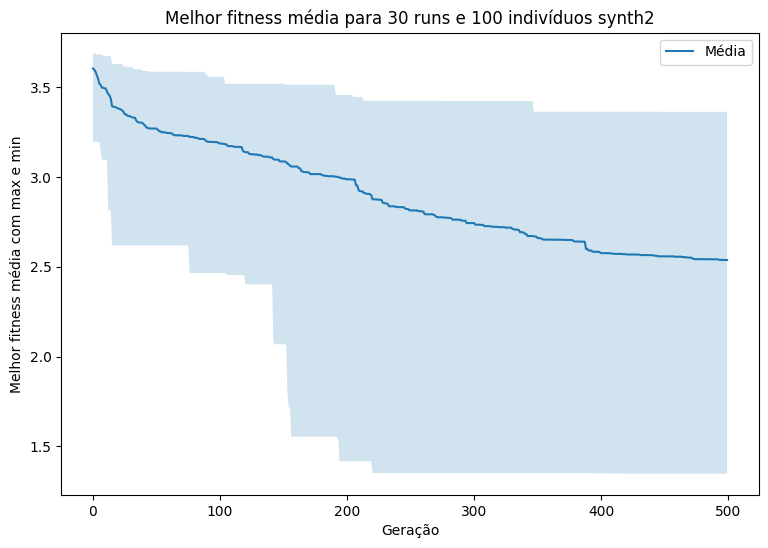

In [18]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_fill_between(best_fit_per_gen_df, ax, 'Média')

ax.legend()
ax.set_ylabel("Melhor fitness média com max e min")
ax.set_xlabel("Geração")
ax.set_title("Melhor fitness média para 30 runs e 100 indivíduos synth2")

# 4 - Comparando a execução das duas melhores execuções

In [19]:
def get_best_test_line_for_gen(n_gens):
    target = f'{n_gens}gen'
    config = data[target]
    print(f"Melhores linhas para gen {n_gens}: ")
    best_run = config[config.test_fit == config.test_fit.min()] 
    print(best_run)
    return best_run

In [20]:
best_run_stats = get_best_test_line_for_gen(500)

Melhores linhas para gen 500: 
    train_fit  test_fit  train_time_seconds  random_seed
8    1.350817  1.357752           73.085844          173
25   1.350817  1.357752          107.472568          942


In [21]:
best_fit_per_gen_df

,min_value,max_value,mean_value
0,3.195707,3.686632,3.604559
1,3.195707,3.686632,3.597902
2,3.195707,3.686632,3.586455
3,3.195707,3.682803,3.566650
4,3.195707,3.682803,3.547849
...,...,...,...
495,1.347332,3.363021,2.538133
496,1.347332,3.363021,2.538133
497,1.347332,3.363021,2.537649
498,1.347332,3.363021,2.537649


In [22]:
best_run_8 = stats_by_run[8]
best_run_25 = stats_by_run[25]

In [23]:
def plot_run_fill_between(stats_df, my_axs, label:str):
    x = range(len(stats_df))
    min_y = stats_df['best_fit']
    std_y = stats_df['std_fit']
    mean_y = stats_df['mean_fit']
    my_axs.plot(x, min_y, '-', label=label)
    my_axs.fill_between(x, min_y, mean_y, alpha=0.2)

Text(0.5, 1.0, 'Best Fitness ao longo das gerações para as melhores duas execuções')

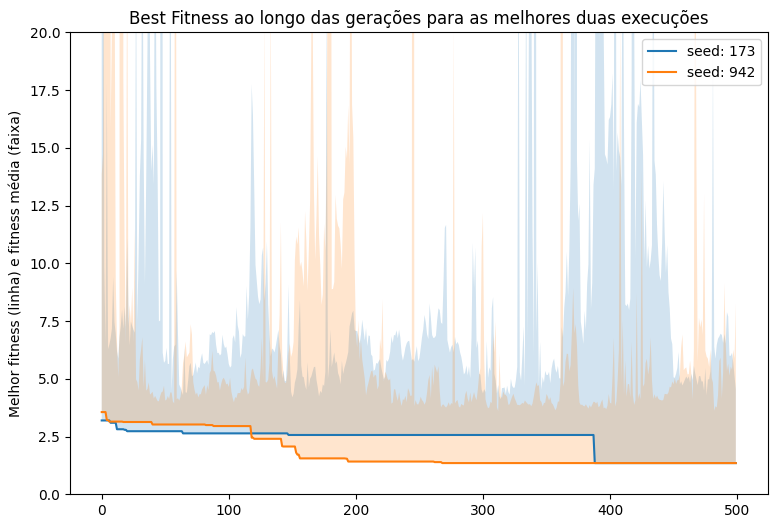

In [25]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_run_fill_between(best_run_8, ax, 'seed: 173')
plot_run_fill_between(best_run_25, ax, 'seed: 942')

ax.set_ylim((0, 20))
ax.legend()
ax.set_ylabel("Melhor fitness (linha) e fitness média (faixa)")
ax.set_title("Best Fitness ao longo das gerações para as melhores duas execuções")

A seed 25 consegue chegar no resultado com cerca de 100 gerações a menos do que a seed 8.